In [ ]:
# Installation de google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# chargement des bibliothèques
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, Callback
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [ ]:
# Chargement et exploration des données
data_dir = "/content/drive/MyDrive/utkcropped"
file_paths = []
ages = []

for file in os.listdir(data_dir):
    if file.endswith(".jpg"):
        age = int(file.split("_")[0])
        file_paths.append(os.path.join(data_dir, file))
        ages.append(age)

In [ ]:
# Création d'un DataFrame
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

df = pd.DataFrame({"file_path": file_paths, "age": ages})
df.head()

,file_path,age
0,/content/drive/MyDrive/utkcropped/80_0_0_20170117175301125.jpg.chip.jpg,80
1,/content/drive/MyDrive/utkcropped/80_0_0_20170117175515838.jpg.chip.jpg,80
2,/content/drive/MyDrive/utkcropped/80_1_0_20170110131358567.jpg.chip.jpg,80
3,/content/drive/MyDrive/utkcropped/80_0_1_20170116003703261.jpg.chip.jpg,80
4,/content/drive/MyDrive/utkcropped/80_1_0_20170110131552667.jpg.chip.jpg,80


In [ ]:
# affichage du nombre de lignes et de colonnes du dataframe
df.shape

(23708, 2)

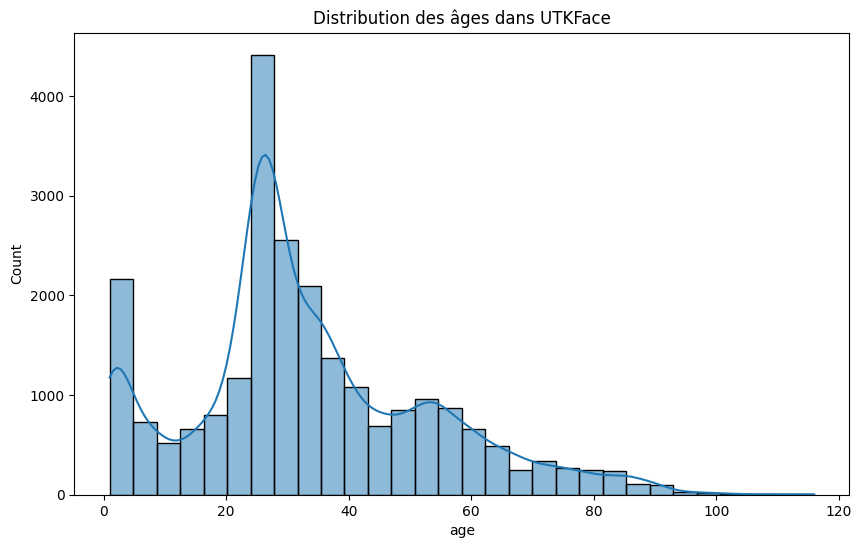

In [ ]:
# Visualisation de la distribution des âges
plt.figure(figsize=(10, 6))
sns.histplot(df["age"], bins=30, kde=True)
plt.title("Distribution des âges dans UTKFace")
plt.show()

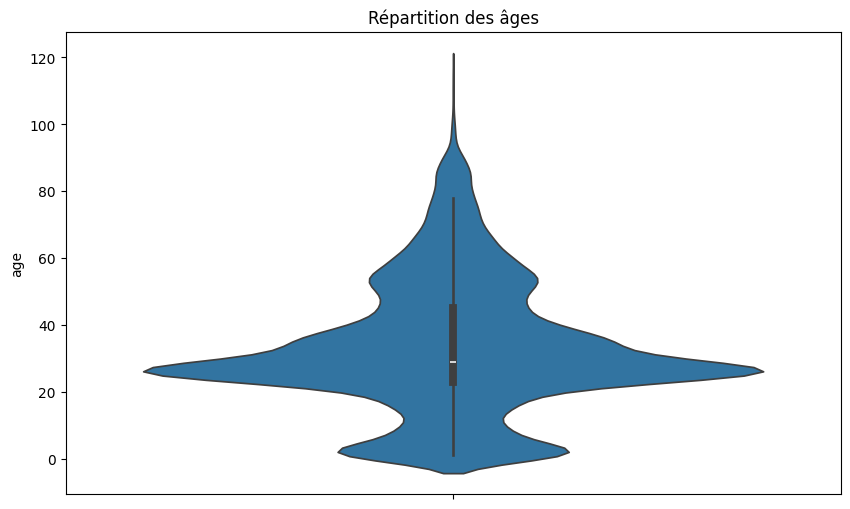

In [ ]:
# Violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(y=df["age"])
plt.title("Répartition des âges")
plt.show()

In [ ]:
df.describe()

,age
count,23708.000000
mean,33.304285
std,19.874866
min,1.000000
25%,23.000000
50%,29.000000
75%,45.000000
max,116.000000


In [ ]:
# Préparation des données
img_height, img_width = 200, 200
batch_size = 32

In [ ]:
def process_image(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [img_height, img_width]) / 255.0
    return img, label

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df["file_path"], df["age"], test_size=0.2, random_state=42)

In [ ]:
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train)).map(process_image).batch(batch_size)
test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test)).map(process_image).batch(batch_size)

In [ ]:
# Data Augmentation
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

In [ ]:
# Modèle CNN pour la régression (prédiction d'âge)
model_regression = Sequential([
    layers.InputLayer(input_shape=(img_height, img_width, 3)),
    data_augmentation,
    layers.Conv2D(32, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(1)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [ ]:
model_regression.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [ ]:
# Entraînement

# Fichiers pour sauvegarder les poids et l'état des epochs
checkpoint_path = "drive/MyDrive/viken_bloc4_cdsd_m2i_age_detection_model_checkpoint.weights.h5"
epoch_file = 'drive/MyDrive/viken_bloc4_cdsd_m2i_age_detection_epoch_checkpoint.txt'

# Définir un callback personnalisé pour sauvegarder l'epoch actuelle
class EpochSaver(Callback):
    def on_epoch_end(self, epoch, logs=None):
        with open(epoch_file, 'w') as f:
            f.write(str(epoch + 1))  # Sauvegarde l'epoch terminée (epoch commence à 0)

# Vérifier si un checkpoint existe déjà et récupérer l'epoch actuelle
initial_epoch = 0
if os.path.exists(checkpoint_path):
    print("Chargement des poids sauvegardés...")
    model_regression.load_weights(checkpoint_path)

    if os.path.exists(epoch_file):
        with open(epoch_file, 'r') as f:
            initial_epoch = int(f.read())  # Lire l'epoch déjà faite
        print(f"Reprise à l'epoch {initial_epoch}")

# Définir les callbacks (ModelCheckpoint + EpochSaver)
checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=False, save_weights_only=True, verbose=1)
epoch_saver = EpochSaver()

# Reprendre l'entraînement en ne faisant que les epochs restantes
total_epochs = 15  # Nombre total d'epochs prévu
remaining_epochs = total_epochs - initial_epoch

if remaining_epochs > 0:
    print(f"Reprise de l'entraînement pour {remaining_epochs} epochs restantes...")
    history_reg = model_regression.fit(train_data, validation_data=test_data,
              initial_epoch=initial_epoch,  # Reprise de l'epoch enregistrée
              epochs=total_epochs,
              batch_size=32,
              callbacks=[checkpoint, epoch_saver])

    # Sauvegarde du modèle complet après l'entraînement
    model_regression.save('drive/MyDrive/viken_bloc4_cdsd_m2i_age_detection_model.h5')
    print("Modèle final sauvegardé sous viken_bloc4_cdsd_m2i_age_detection_model.h5")

else:
    print("Entraînement déjà terminé !")

Reprise de l'entraînement pour 15 epochs restantes...
Epoch 1/15
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 1042.5323 - mae: 27.4233
Epoch 1: saving model to drive/MyDrive/viken_bloc4_cdsd_m2i_age_detection_model_checkpoint.weights.h5
593/593 ━━━━━━━━━━━━━━━━━━━━ 142s 141ms/step - loss: 1041.8604 - mae: 27.4108 - val_loss: 346.2598 - val_mae: 13.9708
Epoch 2/15
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 170.2213 - mae: 9.8879
Epoch 2: saving model to drive/MyDrive/viken_bloc4_cdsd_m2i_age_detection_model_checkpoint.weights.h5
593/593 ━━━━━━━━━━━━━━━━━━━━ 94s 151ms/step - loss: 170.2146 - mae: 9.8878 - val_loss: 145.0943 - val_mae: 9.3797
Epoch 3/15
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 155.0701 - mae: 9.3962
Epoch 3: saving model to drive/MyDrive/viken_bloc4_cdsd_m2i_age_detection_model_checkpoint.weights.h5
593/593 ━━━━━━━━━━━━━━━━━━━━ 140s 148ms/step - loss: 155.0691 - mae: 9.3963 - val_loss: 127.7031 - val_mae: 8.7085
Epoch 4/15
593/593 ━━━━━━━━━━━━━━━━━

Modèle final sauvegardé sous viken_bloc4_cdsd_m2i_age_detection_model.h5


In [ ]:
# Modèle CNN pour la classification par classes d'âge
bins = [0, 10, 20, 30, 40, 60, 80, np.inf]
labels = [0, 1, 2, 3, 4, 5, 6]
df["age_group"] = pd.cut(df["age"], bins=bins, labels=labels)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df["file_path"], df["age_group"].astype(int), test_size=0.2, random_state=42)
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train)).map(process_image).batch(batch_size)
test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test)).map(process_image).batch(batch_size)


In [ ]:
model_classification = Sequential([
    layers.InputLayer(input_shape=(img_height, img_width, 3)),
    data_augmentation,
    layers.Conv2D(32, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(len(labels), activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [ ]:
model_classification.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Entraînement

# Fichiers pour sauvegarder les poids et l'état des epochs
checkpoint_path = "drive/MyDrive/viken_bloc4_cdsd_m2i_age_classification_model_checkpoint.weights.h5"
epoch_file = 'drive/MyDrive/viken_bloc4_cdsd_m2i_age_classification_epoch_checkpoint.txt'

# Définir un callback personnalisé pour sauvegarder l'epoch actuelle
class EpochSaver(Callback):
    def on_epoch_end(self, epoch, logs=None):
        with open(epoch_file, 'w') as f:
            f.write(str(epoch + 1))  # Sauvegarde l'epoch terminée (epoch commence à 0)

# Vérifier si un checkpoint existe déjà et récupérer l'epoch actuelle
initial_epoch = 0
if os.path.exists(checkpoint_path):
    print("Chargement des poids sauvegardés...")
    model_classification.load_weights(checkpoint_path)

    if os.path.exists(epoch_file):
        with open(epoch_file, 'r') as f:
            initial_epoch = int(f.read())  # Lire l'epoch déjà faite
        print(f"Reprise à l'epoch {initial_epoch}")

# Définir les callbacks (ModelCheckpoint + EpochSaver)
checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=False, save_weights_only=True, verbose=1)
epoch_saver = EpochSaver()

# Reprendre l'entraînement en ne faisant que les epochs restantes
total_epochs = 15  # Nombre total d'epochs prévu
remaining_epochs = total_epochs - initial_epoch

if remaining_epochs > 0:
    print(f"Reprise de l'entraînement pour {remaining_epochs} epochs restantes...")
    history_class = model_classification.fit(train_data, validation_data=test_data,
              initial_epoch=initial_epoch,  # Reprise de l'epoch enregistrée
              epochs=total_epochs,
              batch_size=32,
              callbacks=[checkpoint, epoch_saver])

    # Sauvegarde du modèle complet après l'entraînement
    model_classification.save('drive/MyDrive/viken_bloc4_cdsd_m2i_age_classification_model.h5')
    print("Modèle final sauvegardé sous viken_bloc4_cdsd_m2i_age_classification_model.h5")

else:
    print("Entraînement déjà terminé !")


Reprise de l'entraînement pour 15 epochs restantes...
Epoch 1/15
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.4007 - loss: 1.7142
Epoch 1: saving model to drive/MyDrive/viken_bloc4_cdsd_m2i_age_classification_model_checkpoint.weights.h5
593/593 ━━━━━━━━━━━━━━━━━━━━ 79s 128ms/step - accuracy: 0.4008 - loss: 1.7138 - val_accuracy: 0.4810 - val_loss: 1.3047
Epoch 2/15
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.5149 - loss: 1.2082
Epoch 2: saving model to drive/MyDrive/viken_bloc4_cdsd_m2i_age_classification_model_checkpoint.weights.h5
593/593 ━━━━━━━━━━━━━━━━━━━━ 93s 147ms/step - accuracy: 0.5149 - loss: 1.2082 - val_accuracy: 0.5637 - val_loss: 1.0981
Epoch 3/15
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.5457 - loss: 1.1176
Epoch 3: saving model to drive/MyDrive/viken_bloc4_cdsd_m2i_age_classification_model_checkpoint.weights.h5
593/593 ━━━━━━━━━━━━━━━━━━━━ 134s 134ms/step - accuracy: 0.5457 - loss: 1.1176 - val_accuracy: 0.5346 - val_loss: 1.1473


Modèle final sauvegardé sous viken_bloc4_cdsd_m2i_age_classification_model.h5


In [ ]:
# Évaluation
y_pred_reg = model_regression.predict(test_data).flatten()
y_pred_class = np.argmax(model_classification.predict(test_data), axis=1)


149/149 ━━━━━━━━━━━━━━━━━━━━ 14s 90ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 17s 113ms/step


In [ ]:
mae = np.mean(np.abs(y_pred_reg - y_test))
accuracy = accuracy_score(y_test, y_pred_class)
precision = precision_score(y_test, y_pred_class, average='weighted')
recall = recall_score(y_test, y_pred_class, average='weighted')
f1 = f1_score(y_test, y_pred_class, average='weighted')
cm = confusion_matrix(y_test, y_pred_class)

In [ ]:
# Affichage des résultats
print(f"MAE (Régression) : {mae}")
print(f"Accuracy (Classification) : {accuracy}")
print(f"Precision : {precision}")
print(f"Recall : {recall}")
print(f"F1-score : {f1}")
print("Matrice de confusion :\n", cm)

MAE (Régression) : 34.29008315443264
Accuracy (Classification) : 0.5225643188528047
Precision : 0.5336971968518494
Recall : 0.5225643188528047
F1-score : 0.5036320213059398
Matrice de confusion :
 [[ 555   53   37    5    2    1    0]
 [  38  166  124    5    3    0    0]
 [  46  262 1153   72   27    0    1]
 [  23  128  496  116   90    5    0]
 [  17  137  232  119  274   78    7]
 [   8   40   25   26   73  181   13]
 [   2   14    1    1    3   50   33]]


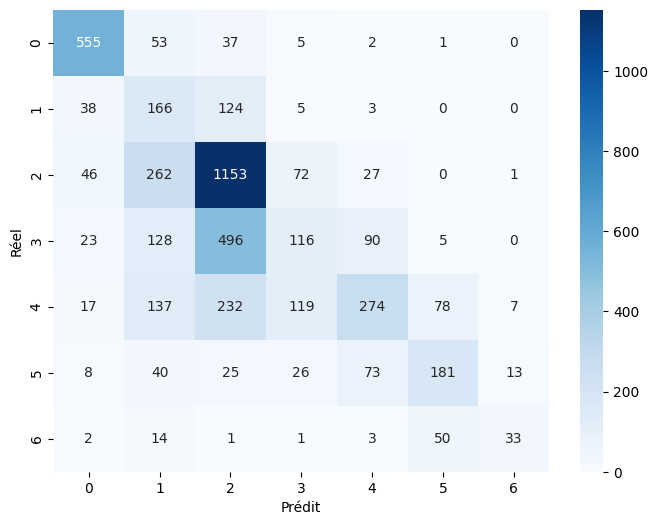

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.show()

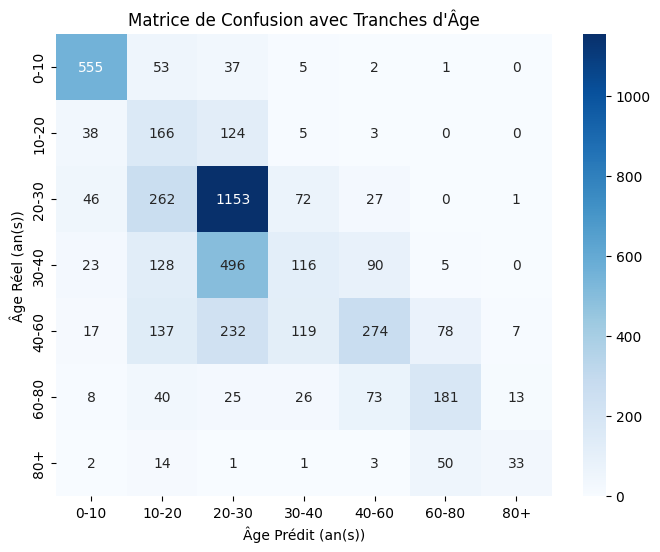

In [ ]:
# Affichage de la heatmap avec les bonnes étiquettes pour les classes
plt.figure(figsize=(8, 6))

# Remplacer les étiquettes par les tranches d'âge dans la matrice de confusion
age_groups = ['0-10', '10-20', '20-30', '30-40', '40-60', '60-80', '80+']  # Correspond aux labels des bins

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=age_groups, yticklabels=age_groups)

plt.xlabel("Âge Prédit (an(s))")
plt.ylabel("Âge Réel (an(s))")
plt.title("Matrice de Confusion avec Tranches d'Âge")
plt.show()

In [ ]:
# Récupérer les valeurs de loss et MAE depuis l'entraînement
loss = history_reg.history['loss']
val_loss = history_reg.history['val_loss']
mae = history_reg.history['mae']
val_mae = history_reg.history['val_mae']


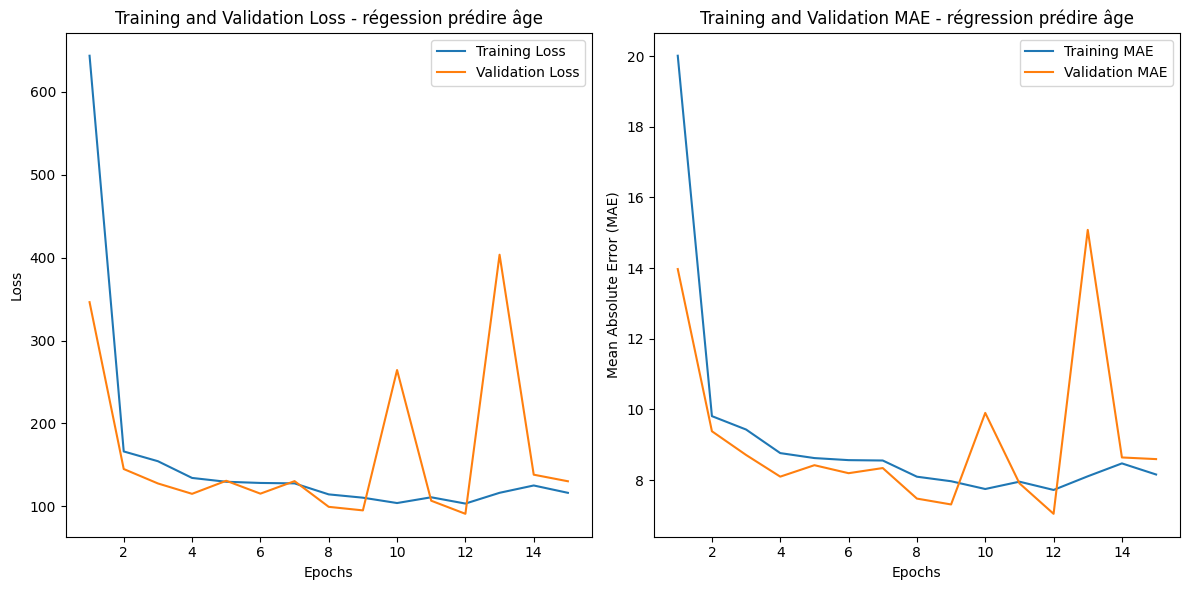

In [ ]:
# Tracer les courbes de loss et MAE
plt.figure(figsize=(12, 6))

# Courbes de Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, 16), loss, label="Training Loss")
plt.plot(range(1, 16), val_loss, label="Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss - régession prédire âge')
plt.legend()

# Courbes de MAE (Mean Absolute Error)
plt.subplot(1, 2, 2)
plt.plot(range(1, 16), mae, label="Training MAE")
plt.plot(range(1, 16), val_mae, label="Validation MAE")
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Training and Validation MAE - régression prédire âge')
plt.legend()

# Affichage des graphiques
plt.tight_layout()
plt.show()

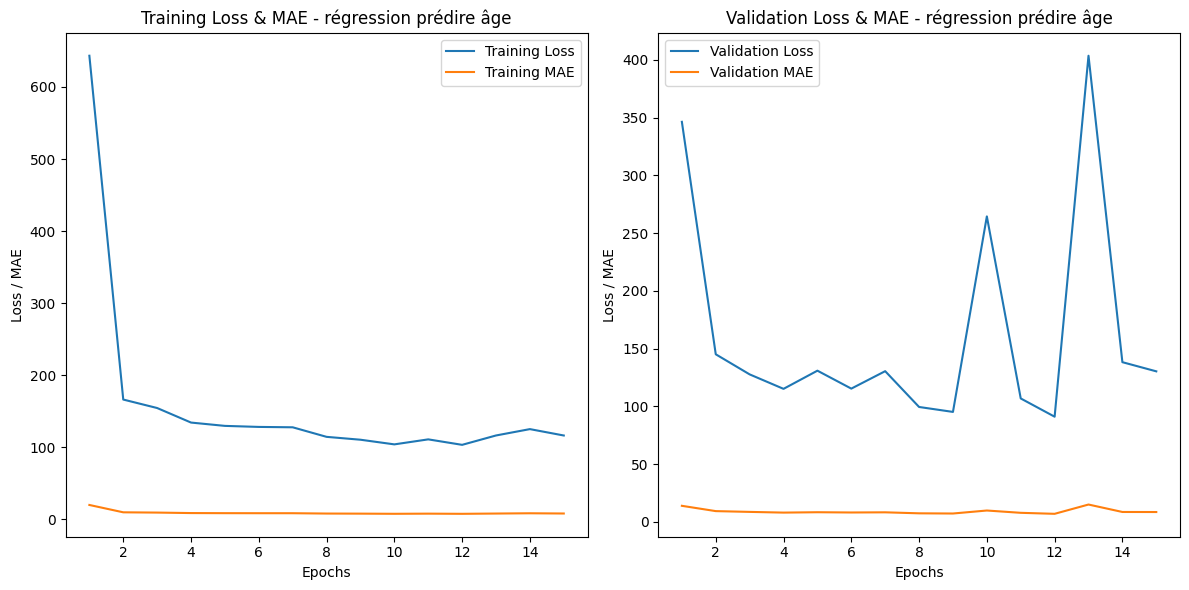

In [ ]:
# Tracer les courbes de loss et MAE pour l'entraînement et la validation
plt.figure(figsize=(12, 6))

# Loss et MAE pour l'entraînement
plt.subplot(1, 2, 1)
# Courbe de Loss pour l'entraînement
plt.plot(range(1, 16), loss, label="Training Loss")
# Courbe de MAE pour l'entraînement
plt.plot(range(1, 16), mae, label="Training MAE")
plt.xlabel('Epochs')
plt.ylabel('Loss / MAE')
plt.title('Training Loss & MAE - régression prédire âge')
plt.legend()

# Loss et MAE pour la validation
plt.subplot(1, 2, 2)  # 1 ligne, 2 colonnes, deuxième vignette
# Courbe de Loss pour la validation
plt.plot(range(1, 16), val_loss, label="Validation Loss")
# Courbe de MAE pour la validation
plt.plot(range(1, 16), val_mae, label="Validation MAE")
plt.xlabel('Epochs')
plt.ylabel('Loss / MAE')
plt.title('Validation Loss & MAE - régression prédire âge')
plt.legend()

# Affichage des graphiques
plt.tight_layout()
plt.show()


In [ ]:
# Récupération des données d'accuracy et de loss (classification multi-classes)
acc = history_class.history['accuracy']
val_acc = history_class.history['val_accuracy']
loss = history_class.history['loss']
val_loss = history_class.history['val_loss']


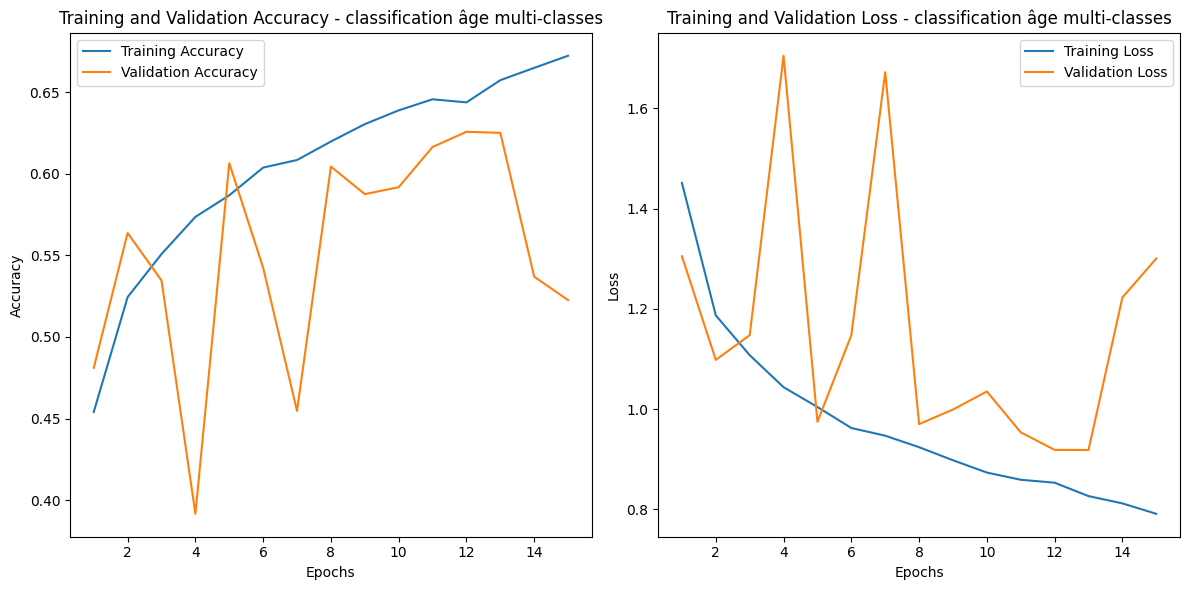

In [ ]:
# Tracer les courbes de comparaison de l'accuracy et de loss entre training et validation (test)
plt.figure(figsize=(12, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(range(1, 16), acc, label="Training Accuracy")
plt.plot(range(1, 16), val_acc, label="Validation Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy - classification âge multi-classes')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(range(1, 16), loss, label="Training Loss")
plt.plot(range(1, 16), val_loss, label="Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss - classification âge multi-classes')
plt.legend()

# Affichage des graphiques
plt.tight_layout()
plt.show()

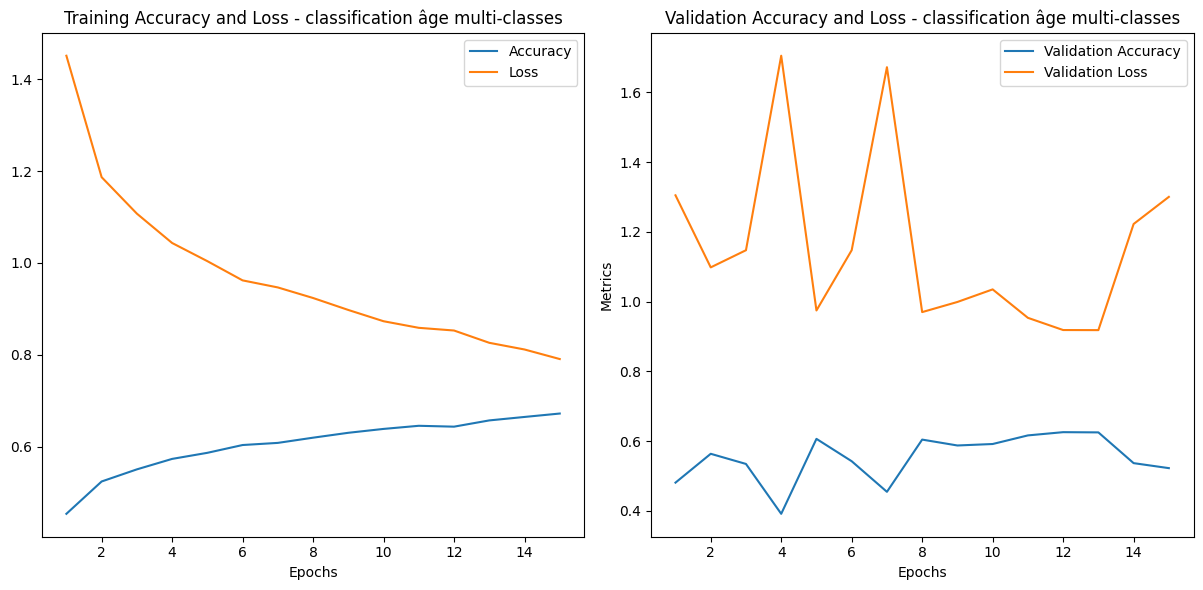

In [ ]:
# Tracer pour chacun des ensembles d'entraînement et de test les courbes de l'accuracy et de loss
plt.figure(figsize=(24, 6))  # Augmenter la largeur pour accueillir 4 subplots

# Training Accuracy and Loss
plt.subplot(1, 4, 3)  # 1 ligne, 4 colonnes, 3e subplot
plt.plot(range(1, 16), acc, label="Accuracy")
plt.plot(range(1, 16), loss, label="Loss")
plt.xlabel('Epochs')
plt.title('Training Accuracy and Loss - classification âge multi-classes')
plt.legend()

# Validation Accuracy and Loss
plt.subplot(1, 4, 4)  # 1 ligne, 4 colonnes, 4e subplot
plt.plot(range(1, 16), val_acc, label="Validation Accuracy")
plt.plot(range(1, 16), val_loss, label="Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.title('Validation Accuracy and Loss - classification âge multi-classes')
plt.legend()

# Affichage des graphiques
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


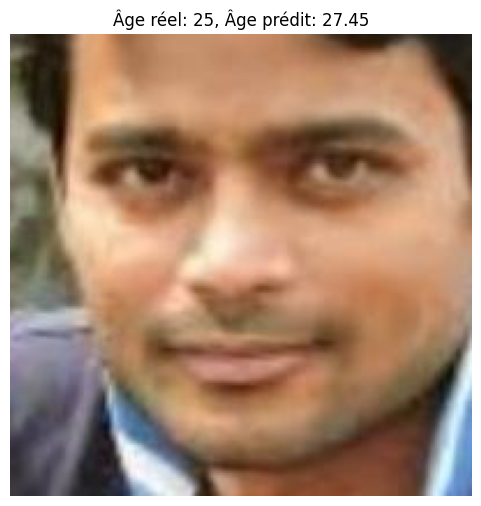

In [ ]:
import os
import random
import tensorflow as tf
import matplotlib.pyplot as plt

# Chemin du dossier contenant les images du dataset n'ayant ni participé à l'entraînement ni participé au test du modèle de détection de l'âge
test_folder = "drive/MyDrive/utkcroppedpredict"

# Lister tous les fichiers d'images dans le dossier
image_files = [f for f in os.listdir(test_folder) if f.endswith(('.jpg', '.png', '.jpeg', '.chip'))]

# Vérifier s'il y a des images dans le dossier
if not image_files:
    print("Aucune image trouvée dans le dossier !")
else:
    # Sélectionner un fichier image au hasard
    random_file = random.choice(image_files)
    file_path = os.path.join(test_folder, random_file)

    # Extraire l'âge réel à partir du nom du fichier (avant le premier "_")
    real_age = int(random_file.split("_")[0])  # Prend la partie avant le premier "_"

    # Charger et prétraiter l'image
    image, _ = process_image(file_path, real_age)  # Passer l'âge réel pour affichage si nécessaire

    # Affichage de l'image
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis('off')

    # Prédire l'âge avec le modèle
    predicted_age = model_regression.predict(tf.expand_dims(image, axis=0)).flatten()[0]

    # Afficher l'âge réel et l'âge prédit
    plt.title(f"Âge réel: {real_age}, Âge prédit: {predicted_age:.2f}")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


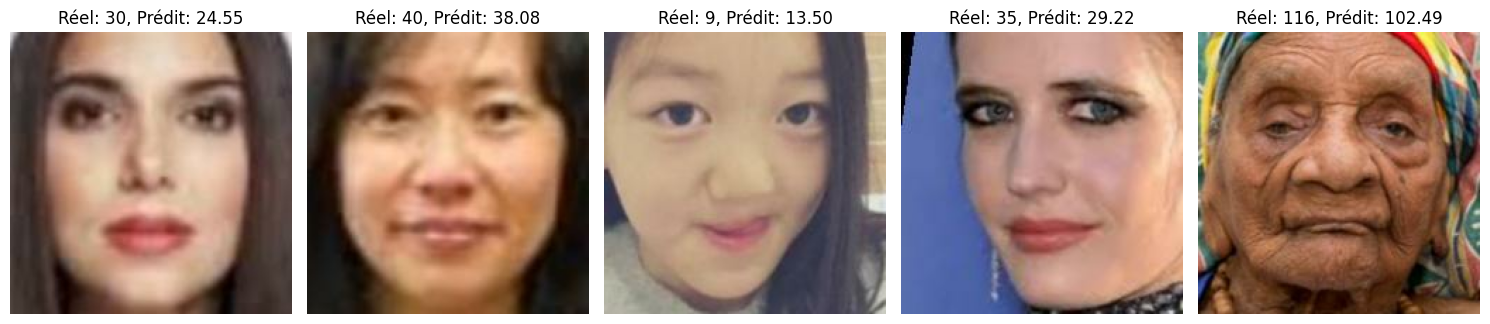

In [ ]:
# Nombre d'images à afficher
num_images = 5

# Lister tous les fichiers d'images dans le dossier
image_files = [f for f in os.listdir(test_folder) if f.endswith(('.jpg', '.png', '.jpeg', '.chip'))]

# Vérifier s'il y a suffisamment d'images dans le dossier
if len(image_files) < num_images:
    print(f"Seulement {len(image_files)} images disponibles, ajustez `num_images`.")
else:
    # Créer une figure pour afficher les images
    plt.figure(figsize=(15, 15))

    # Sélectionner et afficher plusieurs images aléatoires
    for i in range(num_images):
        # Sélectionner un fichier image au hasard
        random_file = random.choice(image_files)
        file_path = os.path.join(test_folder, random_file)

        # Extraire l'âge réel à partir du nom du fichier (avant le premier "_")
        real_age = int(random_file.split("_")[0])  # Prend la partie avant le premier "_"

        # Charger et prétraiter l'image
        image, _ = process_image(file_path, real_age)  # Passer l'âge réel pour affichage si nécessaire

        # Prédire l'âge de l'image avec le modèle de régression
        predicted_age = model_regression.predict(tf.expand_dims(image, axis=0)).flatten()[0]

        # Afficher l'image dans un sous-graphe (médaillon)
        plt.subplot(1, num_images, i + 1)  # 1 ligne et 'num_images' colonnes
        plt.imshow(image)
        plt.axis('off')

        # Afficher l'âge réel et prédit sur l'image
        plt.title(f"Réel: {real_age}, Prédit: {predicted_age:.2f}")

    # Affichage de toutes les images
    plt.tight_layout()
    plt.show()

In [ ]:
# Essai prédiction d'âge avec photo nouvelle
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Fonction de prétraitement pour l'image (en tenant compte de la taille de 200x200)
def process_image(image_path, target_size=(200, 200)):
    # Charger l'image avec OpenCV
    img = cv2.imread(image_path)

    # Convertir l'image en RGB (OpenCV charge par défaut en BGR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Redimensionner l'image à la taille que le modèle attend
    img_resized = cv2.resize(img, target_size)

    # Normaliser l'image (par exemple, normalisation entre 0 et 1)
    img_array = np.expand_dims(img_resized, axis=0)  # Ajouter la dimension du batch
    img_array = img_array / 255.0  # Normaliser les pixels entre 0 et 1

    return img_array

# Chemin du fichier de l'image à prédire
img_path = '/content/20250114_080750.jpg'  # Remplace avec le chemin de ton image

# Appliquer le prétraitement à l'image
image_array = process_image(img_path)

# Charger le modèle (si non chargé encore, assure-toi qu'il est déjà chargé et entraîné)
# model_regression = tf.keras.models.load_model('path_to_your_model')  # Si tu n'as pas déjà chargé le modèle

# Prédiction de l'âge avec le modèle
predicted_age = model_regression.predict(image_array).flatten()[0]

# Afficher l'image et l'âge prédit
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir en RGB pour affichage
plt.imshow(img)
plt.axis('off')
plt.title(f"Âge prédit : {predicted_age:.2f}")
plt.show()